<a href="https://colab.research.google.com/github/ZhongyuGuo/M4R/blob/main/Classification_3cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import argparse
import pprint
import gensim
#from glove import Glove
#from glove import Corpus
import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import keras
import re
import random
import torch

In [2]:
from google.colab import drive
drive.mount("/content/drive")
df=pd.read_csv("/content/drive/My Drive/M4R/papers2019_200000.csv")

Mounted at /content/drive


In [3]:
catlist=['math','cs','quant-ph','hep-ex','hep-th','astro-ph','nucl-ex','nucl-th']

In [4]:
cat1=catlist[0]
cat2=catlist[2]
cat3=catlist[4]
#cat4=catlist[6]
#cat5=catlist[7]

In [5]:
df1=df[df['categories']==cat1][0:1500].reset_index(drop=True)
df2=df[df['categories']==cat2][0:1500].reset_index(drop=True)
df3=df[df['categories']==cat3][0:1500].reset_index(drop=True)
#df4=df[df['categories']==cat4][0:1500].reset_index(drop=True)
#df5=df[df['categories']==cat5][0:1500].reset_index(drop=True)

In [6]:
text=df1.append(df2).reset_index(drop=True)
text=text.append(df3).reset_index(drop=True)
#text=text.append(df4).reset_index(drop=True)
#text=text.append(df5).reset_index(drop=True)

In [7]:
RANDOM_STATE = 50
EPOCHS =15
BATCH_SIZE = 256
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 1
SAVE_MODEL = True

In [8]:
def format_text(text):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    text = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', text)

    # Remove references to figures
    text = re.sub(r'\((\d+)\)', r'', text)

    text=re.sub(' the ',' ',text)
    text=re.sub(' of ',' ',text)
    text=re.sub(' and ',' ',text)
    text=re.sub(' a ',' ',text)
    text=re.sub(' in ',' ',text)
    text=re.sub(' to ',' ',text)
    text=re.sub(' with ',' ',text)
    text=re.sub(' for ',' ',text)
    text=re.sub(' by ',' ',text)
    text=re.sub(' on ',' ',text)
    text=re.sub(' as ',' ',text)
    text=re.sub(' an ',' ',text)
    text=re.sub(' at ',' ',text)
    text=re.sub(' we ',' ',text)
    text=re.sub(' is ',' ',text)
    text=re.sub(' this ',' ',text)
    text=re.sub(' are ',' ',text)
    text=re.sub(' which ',' ',text)
    text=re.sub(' be ',' ',text)
    text=re.sub(' it ',' ',text)
    text=re.sub(' that ',' ',text)
    text=re.sub(' from ',' ',text)
    text=re.sub(' can ',' ',text)
    text=re.sub(' these ',' ',text)
    text=re.sub(' our ',' ',text)
    text=re.sub(' has ',' ',text)
    text=re.sub(' have ',' ',text)
    text=re.sub('.We ','.',text)
    text=re.sub('.That ','.',text)
    text=re.sub('.The ','.',text)
    text=re.sub('.From ','.',text)
    text=re.sub('.Our ','.',text)
    text=re.sub('.In ','.',text)
    text=re.sub('.These ','.',text)
    text=re.sub('.This ','.',text)
    text=re.sub(',that ',',',text)

    # Remove double spaces
    text = re.sub(r'\s\s', ' ', text)
    
    return text

In [9]:
formatted = []

# Iterate through all the original abstracts
for a in text['abstracts']:
    formatted.append(format_text(a))
len(formatted)

4500

In [10]:
def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    features = tokenizer.texts_to_sequences(texts)

    categories=[cat1,cat2,cat3]
    labels=np.zeros((len(text),len(categories)))
    for i in range(len(text)):
      ind=categories.index(text.iloc[i,1])
      labels[i,ind]=1
    return word_idx, idx_word, num_words, word_counts, features,labels


In [11]:
TRAINING_LENGTH = 50
filters = '.,!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts,features,labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=True, filters=filters)

There are 22110 unique words.


In [12]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [13]:
#max_len=max([len(i) for i in features])
pad = len(max(features, key=len))
features=[i + [0]*(pad-len(i)) for i in features]

In [14]:
features1=np.array(features)

In [15]:
X_input=np.zeros([3000,len(features[0])])
X_input[0:1000,:]=features1[0:1000,:]
X_input[1000:2000]=features1[1500:2500,:]
X_input[2000:3000]=features1[3000:4000,:]
#X_input[3000:4000]=features1[4500:5500,:]
#X_input[4000:5000]=features1[6000:7000,:]

In [16]:
X_test=np.zeros([1500,len(features[0])])
X_test[0:500,:]=features1[1000:1500,:]
X_test[500:1000]=features1[2500:3000,:]
X_test[1000:1500]=features1[4000:4500,:]
#X_test[1500:2000]=features1[5500:6000,:]
#X_test[2000:2500]=features1[7000:7500,:]

In [17]:
y_input=np.zeros([3000,3])
y_input[0:1000,:]=labels[0:1000,:]
y_input[1000:2000]=labels[1500:2500,:]
y_input[2000:3000]=labels[3000:4000,:]
#y_input[3000:4000]=labels[4500:5500,:]
#y_input[4000:5000]=labels[6000:7000,:]

In [18]:
y_test=np.zeros([1500,3])
y_test[0:500,:]=labels[1000:1500,:]
y_test[500:1000]=labels[2500:3000,:]
y_test[1000:1500]=labels[4000:4500,:]
#y_test[1500:2000]=labels[5500:6000,:]
#y_test[2000:2500]=labels[7000:7500,:]

In [19]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    y_train, y_valid = np.array(train_labels), np.array(valid_labels)

    # Memory management
    import gc
    gc.enable()
    del features, train_features, labels, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [20]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    X_input, y_input)
y_train.shape

(2100, 3)

In [21]:
glove=np.loadtxt('/content/drive/My Drive/M4R/glove.6B.100d.txt',dtype='str', comments=None)
glove.shape

(400000, 101)

In [22]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

In [23]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 9126 words without pre-trained embeddings.


In [24]:
import gc
gc.enable()
del vectors
gc.collect()

150

In [25]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [26]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

#from keras.utils import plot_model

In [27]:
def make_word_level_model(embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(len(labels[0]), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=2,
    bi_direc=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2211000   
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [28]:
from IPython.display import Image
model_name = 'pre-trained-rnn'
model_dir = '../models/'

#plot_model(model,show_shapes=True)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint



def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'/content/drive/My Drive/M4R/3catedery.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name,SAVE_MODEL)

In [30]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

Epoch 1/15
9/9 [==============================] - 60s 3s/step - loss: 1.0949 - accuracy: 0.3793 - val_loss: 1.0495 - val_accuracy: 0.5567
Epoch 2/15
9/9 [==============================] - 28s 3s/step - loss: 1.0214 - accuracy: 0.5033 - val_loss: 0.8037 - val_accuracy: 0.6244
Epoch 3/15
9/9 [==============================] - 28s 3s/step - loss: 0.8224 - accuracy: 0.6235 - val_loss: 0.7842 - val_accuracy: 0.6289
Epoch 4/15
9/9 [==============================] - 28s 3s/step - loss: 0.8098 - accuracy: 0.6283 - val_loss: 0.6798 - val_accuracy: 0.6967
Epoch 5/15
9/9 [==============================] - 28s 3s/step - loss: 0.6933 - accuracy: 0.7039 - val_loss: 0.5788 - val_accuracy: 0.7522
Epoch 6/15
9/9 [==============================] - 28s 3s/step - loss: 0.6127 - accuracy: 0.7623 - val_loss: 0.4655 - val_accuracy: 0.8244
Epoch 7/15
9/9 [==============================] - 28s 3s/step - loss: 0.4997 - accuracy: 0.8265 - val_loss: 0.3910 - val_accuracy: 0.8533
Epoch 8/15
9/9 [==================

In [31]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'/content/drive/My Drive/M4R/3cat64edery.h5')

    loss, acc = model.evaluate(X_valid, y_valid, batch_size=BATCH_SIZE, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc*100))

    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc*100))

    if return_model:
        return model

In [32]:
model = load_and_evaluate(model_name, return_model=True)

4/4 [==============================] - 2s 233ms/step - loss: 0.3455 - accuracy: 0.8889
Test Loss: 0.3454866409301758
Test Accuracy: 88.88888955116272
6/6 [==============================] - 2s 258ms/step - loss: 0.3480 - accuracy: 0.8793
Test Loss: 0.34800177812576294
Test Accuracy: 87.93333172798157


In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.127425527572632)

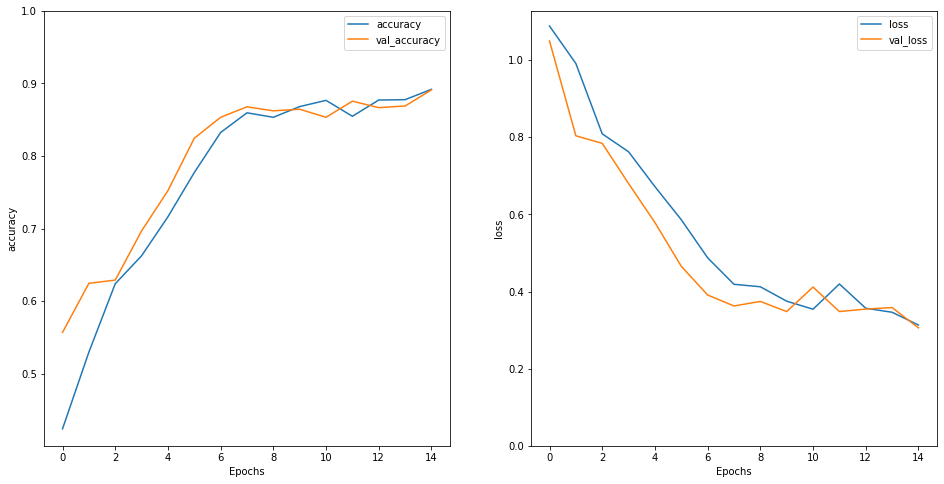

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)